<a href="https://colab.research.google.com/github/gbessardon/amazon_product_recommendation_system_project/blob/main/Recommendation_Systems_Learner_Notebook_Full_Code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Project: Amazon Product Recommendation System**

# **Marks: 60**


Welcome to the project on Recommendation Systems. We will work with the Amazon product reviews dataset for this project. The dataset contains ratings of different electronic products. It does not include information about the products or reviews to avoid bias while building the model.

--------------
## **Context:**
--------------

Today, information is growing exponentially with volume, velocity and variety throughout the globe. This has lead to information overload, and too many choices for the consumer of any business. It represents a real dilemma for these consumers and they often turn to denial. Recommender Systems are one of the best tools that help recommending products to consumers while they are browsing online. Providing personalized recommendations which is most relevant for the user is what's most likely to keep them engaged and help business.

E-commerce websites like Amazon, Walmart, Target and Etsy use different recommendation models to provide personalized suggestions to different users. These companies spend millions of dollars to come up with algorithmic techniques that can provide personalized recommendations to their users.

Amazon, for example, is well-known for its accurate selection of recommendations in its online site. Amazon's recommendation system is capable of intelligently analyzing and predicting customers' shopping preferences in order to offer them a list of recommended products. Amazon's recommendation algorithm is therefore a key element in using AI to improve the personalization of its website. For example, one of the baseline recommendation models that Amazon uses is item-to-item collaborative filtering, which scales to massive data sets and produces high-quality recommendations in real-time.

----------------
## **Objective:**
----------------

You are a Data Science Manager at Amazon, and have been given the task of building a recommendation system to recommend products to customers based on their previous ratings for other products. You have a collection of labeled data of Amazon reviews of products. The goal is to extract meaningful insights from the data and build a recommendation system that helps in recommending products to online consumers.

-----------------------------
## **Dataset:**
-----------------------------

The Amazon dataset contains the following attributes:

- **userId:** Every user identified with a unique id
- **productId:** Every product identified with a unique id
- **Rating:** The rating of the corresponding product by the corresponding user
- **timestamp:** Time of the rating. We **will not use this column** to solve the current problem

**Note:** The code has some user defined functions that will be usefull while making recommendations and measure model performance, you can use these functions or can create your own functions.

Sometimes, the installation of the surprise library, which is used to build recommendation systems, faces issues in Jupyter. To avoid any issues, it is advised to use **Google Colab** for this project.

Let's start by mounting the Google drive on Colab.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**Installing surprise library**

In [ ]:
# Installing the surprise library
!pip install surprise

## **Importing the necessary libraries and overview of the dataset**

In [ ]:
# Basic libraries of python for numeric and dataframe computations
import numpy as np, pandas as pd

# Basic library for data visualization
import matplotlib.pyplot as plt

# Slightly advanced library for data visualization
import seaborn as sns

# A dictionary output that does not raise a key error
from collections import defaultdict


### **Loading the data**
- Import the Dataset
- Add column names ['user_id', 'prod_id', 'rating', 'timestamp']
- Drop the column timestamp
- Copy the data to another DataFrame called **df**

In [ ]:
 # I use the pandas function read_csv to load the dataset
 df=pd.read_csv('/content/drive/MyDrive/ratings_Electronics.csv')

  # Add column names ['user_id', 'prod_id', 'rating', 'timestamp']
 df.columns=['user_id','prod_id','rating', 'timestamp']

 # Drop the column timestamp
 df=df.drop(['timestamp'],axis=1)



In [ ]:
# I use the method info to ensure the previous operations were made correctly
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7824481 entries, 0 to 7824480
Data columns (total 3 columns):
 #   Column   Dtype  
---  ------   -----  
 0   user_id  object 
 1   prod_id  object 
 2   rating   float64
dtypes: float64(1), object(2)
memory usage: 179.1+ MB


**As this dataset is very large and has 7,824,482 observations, it is not computationally possible to build a model using this. Moreover, many users have only rated a few products and also some products are rated by very few users. Hence, we can reduce the dataset by considering certain logical assumptions.**

Here, we will be taking users who have given at least 50 ratings, and the products that have at least 5 ratings, as when we shop online we prefer to have some number of ratings of a product.

In [ ]:
# Get the column containing the users
users = df.user_id

# Create a dictionary from users to their number of ratings
ratings_count = dict()

for user in users:

    # If we already have the user, just add 1 to their rating count
    if user in ratings_count:
        ratings_count[user] += 1

    # Otherwise, set their rating count to 1
    else:
        ratings_count[user] = 1

In [ ]:
# We want our users to have at least 50 ratings to be considered
RATINGS_CUTOFF = 50

remove_users = []

for user, num_ratings in ratings_count.items():
    if num_ratings < RATINGS_CUTOFF:
        remove_users.append(user)

df = df.loc[ ~ df.user_id.isin(remove_users)]

In [ ]:
# Get the column containing the products
prods = df.prod_id

# Create a dictionary from products to their number of ratings
ratings_count = dict()

for prod in prods:

    # If we already have the product, just add 1 to its rating count
    if prod in ratings_count:
        ratings_count[prod] += 1

    # Otherwise, set their rating count to 1
    else:
        ratings_count[prod] = 1

In [ ]:
# We want our item to have at least 5 ratings to be considered
RATINGS_CUTOFF = 5

remove_users = []

for user, num_ratings in ratings_count.items():
    if num_ratings < RATINGS_CUTOFF:
        remove_users.append(user)

df_final = df.loc[~ df.prod_id.isin(remove_users)]

In [ ]:
# Print a few rows of the imported dataset
df_final.head()

,user_id,prod_id,rating
1309,A3LDPF5FMB782Z,1400501466,5.0
1321,A1A5KUIIIHFF4U,1400501466,1.0
1334,A2XIOXRRYX0KZY,1400501466,3.0
1450,AW3LX47IHPFRL,1400501466,5.0
1455,A1E3OB6QMBKRYZ,1400501466,1.0


## **Exploratory Data Analysis**

### **Shape of the data**

### **Check the number of rows and columns and provide observations.**

Here we show two methods are possible to check the number of rows and columns

In [ ]:
# The info method that provide more information about the dataset
df_final.info()

<class 'pandas.core.frame.DataFrame'>
Index: 65290 entries, 1309 to 7824426
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   user_id  65290 non-null  object 
 1   prod_id  65290 non-null  object 
 2   rating   65290 non-null  float64
dtypes: float64(1), object(2)
memory usage: 2.0+ MB


In [ ]:
# The shape method that creates a tuple (row,columns) of the dataset
print(f'There are {df_final.shape[0]} rows and {df_final.shape[1]} in the data.' )

There are 65290 rows and 3 in the data.




*   There are  **65290 rows** and **3 columns** in the data.





### **Data types**

In [ ]:
# Check Data types and provide observations
# The info method allows to check the column data types
df_final.info()

<class 'pandas.core.frame.DataFrame'>
Index: 65290 entries, 1309 to 7824426
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   user_id  65290 non-null  object 
 1   prod_id  65290 non-null  object 
 2   rating   65290 non-null  float64
dtypes: float64(1), object(2)
memory usage: 2.0+ MB




*   Columns **user_id** and **prod_id** are **objects**
*   Column rating is a **float**



### **Checking for missing values**

In [ ]:
# We look at the Non-null count in the info() method
df_final.info()

<class 'pandas.core.frame.DataFrame'>
Index: 65290 entries, 1309 to 7824426
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   user_id  65290 non-null  object 
 1   prod_id  65290 non-null  object 
 2   rating   65290 non-null  float64
dtypes: float64(1), object(2)
memory usage: 2.0+ MB


We see that for the 3 columns there are 65290 non-null values.
**So there are no missing values**

### **Summary Statistics**

In [ ]:
# We use the describe method to provide a summary statistics of 'rating'
df_final.describe()

,rating
count,65290.000000
mean,4.294808
std,0.988915
min,1.000000
25%,4.000000
50%,5.000000
75%,5.000000
max,5.000000




*   The mean rating is **4.294808**
*   The 25% quartile is **4**, so **75% of the ratings are greater than 4**
*   Therefore the rating is **highly skewed towards 4 and 5**. It suggests that people tend to not give a rating for an object they don't like, or the object with low ratings have been bought less than 5 times.






### **Checking the rating distribution**

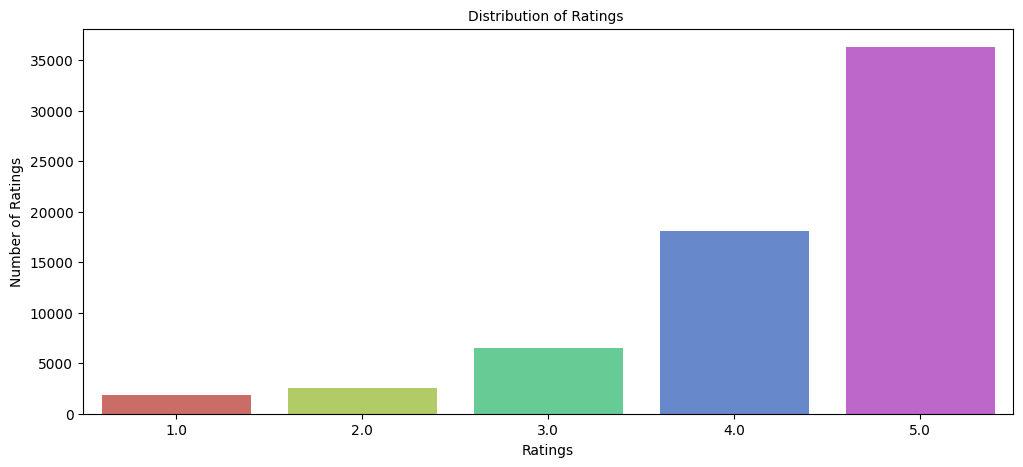

In [ ]:
# Create the bar plot and provide observations
# Fix the figure size
plt.figure(figsize = (12, 5))

ax = sns.countplot(x = "rating",hue = "rating", data = df_final, palette=sns.color_palette("hls", 5), legend=False)

plt.tick_params(labelsize = 10)

plt.title("Distribution of Ratings ", fontsize = 10)

# Set the xlabel of the plot
plt.xlabel("Ratings", fontsize = 10)

# Set the ylabel of the plot
plt.ylabel("Number of Ratings", fontsize = 10)

# Display the plot
plt.show()


*   **The rating distribution confirms the high skew towards 4 and 5**
*   Ratings 1,2,3 have a count lower than 10000 while 4 is nearly 20000 and 5 more than 35000




### **Checking the number of unique users and items in the dataset**

In [ ]:
# We use the nunique method to determine the number of unique user id and product id in the data
# NIumber of unique user id
unique_users=df_final['user_id'].nunique()
# Number of unique product id
unique_products=df_final['prod_id'].nunique()

print(f'There are {unique_users} unique user id and {unique_products} unique product id.')

There are 1540 unique user id and 5689 unique product id.




*   We used the nunique method to show that there are **1540 unique user id** and **5689 unique product id**.
*   As per the number of unique users and products, there is a possibility of 1540 * 5689 = 8761060 ratings in the dataset. But we only have 65290 ratings, i.e., not every user has rated every objects in the dataset. And we can build a recommendation system to recommend objects to users which they have not rated/purchased.



### **Users with the most number of ratings**

In [ ]:
# We use the value count nested with the head method to determine the top 10 users based on the number of ratings
df_final['user_id'].value_counts().head(10)

user_id
ADLVFFE4VBT8      295
A3OXHLG6DIBRW8    230
A1ODOGXEYECQQ8    217
A36K2N527TXXJN    212
A25C2M3QF9G7OQ    203
A680RUE1FDO8B     196
A1UQBFCERIP7VJ    193
A22CW0ZHY3NJH8    193
AWPODHOB4GFWL     184
AGVWTYW0ULXHT     179
Name: count, dtype: int64

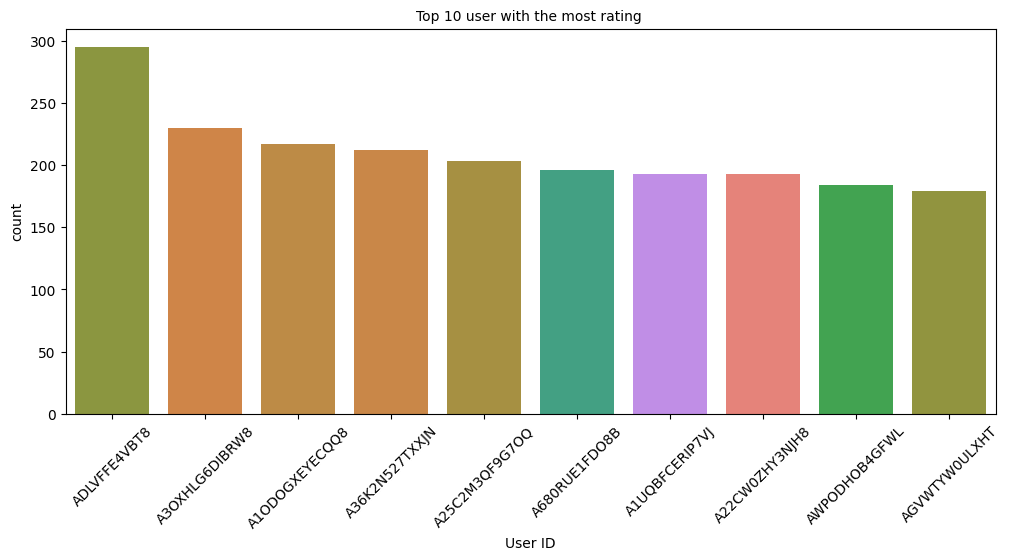

In [ ]:
# We propose a count plot for a nicer visualisation
# Fix the figure size
plt.figure(figsize = (12, 5))

ax = sns.countplot(x= "user_id", data = df_final,
                   order=pd.value_counts(df_final['user_id']).iloc[:10].index,hue= "user_id",legend=False)

plt.tick_params(labelsize = 10)

plt.title("Top 10 user with the most rating ", fontsize = 10)

# Set the xlabel of the plot
plt.xlabel("Number of Ratings", fontsize = 10)

# Set the ylabel of the plot
plt.xlabel("User ID", fontsize = 10)
plt.xticks(rotation=45)

# Display the plot
plt.show()

We have used the value count nested with the head method to determine the top 10 users based on the number of ratings as follows:


1. user ADLVFFE4VBT8 with 295 ratings
2. user A3OXHLG6DIBRW8 with 230 ratings
3. user A1ODOGXEYECQQ8 with 217 ratings
4. user A36K2N527TXXJN with 212 ratings
5. user A25C2M3QF9G7OQ with 203 ratings
6. user A680RUE1FDO8B with 196 ratings
7. user A1UQBFCERIP7VJ with 193 ratings
8. user A22CW0ZHY3NJH8 with 193 ratings
9. user AWPODHOB4GFWL  with 184 ratings
10. user AGVWTYW0ULXHT with 179 ratings

We see that user ADLVFFE4VBT8 with the most ratings  has 65 more ratings  than the second user with the most ratings user A3OXHLG6DIBRW8 In comparison there are only 51 ratings  between user A3OXHLG6DIBRW8 and the 10th user with the most ratings user AGVWTYW0ULXHT.




**Now that we have explored and prepared the data, let's build the first recommendation system.**

## **Model 1: Rank Based Recommendation System**

Rank-based recommendation system provides recommendations based on the most popular items. This kind of recommendation system is useful when we have **cold start** problems. In our case the **cold start** refers to the issue when we get a **new user into the system and the machine is not able to recommend a product to the new user**, as the user did not have any historical interactions in the dataset. In those cases, we can use a rank-based recommendation system to recommend a product to the new user.

To build the rank-based recommendation system, we take the average of all the ratings provided to each product and then rank them based on their average rating.

In [ ]:
# I use the grouby and mean methods to calculate the average rating for each product
average_rating = df_final.groupby('prod_id')['rating'].mean()
# I use the grouby and count methods talculate the count of ratings for each product
count_rating = df_final.groupby('prod_id')['rating'].count()
# Create a dataframe with calculated average and count of ratings
final_rating = pd.DataFrame({'avg_rating': average_rating, 'rating_count': count_rating})
# I use the sort_values method to sort the dataframe by average of ratings in the descending order
final_rating = final_rating.sort_values('avg_rating', ascending=False)
# I use the head() method to see the first five records of the "final_rating" dataset
final_rating.head()

,avg_rating,rating_count
prod_id,,
B00LGQ6HL8,5.0,5
B003DZJQQI,5.0,14
B005FDXF2C,5.0,7
B00I6CVPVC,5.0,7
B00B9KOCYA,5.0,8


We can see above that the average ratings are 5 for the five first records suggesting that the final_rating data frame has been correctly classified in descending order.

Let´s create  a function to recommend n product based on the highest average rating with a minimum interaction threshold

In [ ]:
# Defining a function to get the top n products based on the highest average rating and minimum interactions
def top_n_products(data, n, min_interaction = 100):

    # Finding products with minimum number of interactions
    recommendations = data[data['rating_count'] > min_interaction]

    # Sorting values with respect to average rating
    recommendations = recommendations.sort_values(by = 'avg_rating', ascending = False)

    return recommendations.index[:n]


### **Recommending top 5 products with 50 minimum interactions based on popularity**

In [ ]:
 # I use the previously defined top_n_products( on the final_ratings dataframe with n=5 and min_interaction = 50
 top_n_products(final_rating, 5, min_interaction = 50)


Index(['B001TH7GUU', 'B003ES5ZUU', 'B0019EHU8G', 'B006W8U2MU', 'B000QUUFRW'], dtype='object', name='prod_id')

### **Recommending top 5 products with 100 minimum interactions based on popularity**

In [ ]:
 # I use the previously defined top_n_restaurant on the final_ratings dataframe with n=5 and min_interaction = 100
top_n_products(final_rating, 5, min_interaction = 100)

Index(['B003ES5ZUU', 'B000N99BBC', 'B007WTAJTO', 'B002V88HFE', 'B004CLYEDC'], dtype='object', name='prod_id')

We have recommended the **top 5** products by using the popularity recommendation system with different minmum interaction threshold **(50 and 100 respectively)**
We note that only the product 'B003ES5ZUU' appears in both list which means that **4 out of 5 most popular products have less than 100 ratings**.

Now, let's build a recommendation system using **collaborative filtering.**

## **Model 2: Collaborative Filtering Recommendation System**

### **Building a baseline user-user similarity based recommendation system**

- Below, we are building **similarity-based recommendation systems** using `cosine` similarity and using **KNN to find similar users** which are the nearest neighbor to the given user.  
- We will be using a new library, called `surprise`, to build the remaining models. Let's first import the necessary classes and functions from this library.

In [ ]:
# To compute the accuracy of models
from surprise import accuracy

# Class is used to parse a file containing ratings, data should be in structure - user ; item ; rating
from surprise.reader import Reader

# Class for loading datasets
from surprise.dataset import Dataset

# For tuning model hyperparameters
from surprise.model_selection import GridSearchCV

# For splitting the rating data in train and test datasets
from surprise.model_selection import train_test_split

# For implementing similarity-based recommendation system
from surprise.prediction_algorithms.knns import KNNBasic

# For implementing matrix factorization based recommendation system
from surprise.prediction_algorithms.matrix_factorization import SVD

# for implementing K-Fold cross-validation
from surprise.model_selection import KFold

# For implementing clustering-based recommendation system
from surprise import CoClustering

**Before building the recommendation systems, let's  go over some basic terminologies we are going to use:**

**Relevant item:** An item (product in this case) that is actually **rated higher than the threshold rating** is relevant, if the **actual rating is below the threshold then it is a non-relevant item**.  

**Recommended item:** An item that's **predicted rating is higher than the threshold is a recommended item**, if the **predicted rating is below the threshold then that product will not be recommended to the user**.  


**False Negative (FN):** It is the **frequency of relevant items that are not recommended to the user**. If the relevant items are not recommended to the user, then the user might not buy the product/item. This would result in the **loss of opportunity for the service provider**, which they would like to minimize.

**False Positive (FP):** It is the **frequency of recommended items that are actually not relevant**. In this case, the recommendation system is not doing a good job of finding and recommending the relevant items to the user. This would result in **loss of resources for the service provider**, which they would also like to minimize.

**Recall:** It is the **fraction of actually relevant items that are recommended to the user**, i.e., if out of 10 relevant products, 6 are recommended to the user then recall is 0.60. Higher the value of recall better is the model. It is one of the metrics to do the performance assessment of classification models.

**Precision:** It is the **fraction of recommended items that are relevant actually**, i.e., if out of 10 recommended items, 6 are found relevant by the user then precision is 0.60. The higher the value of precision better is the model. It is one of the metrics to do the performance assessment of classification models.

**While making a recommendation system, it becomes customary to look at the performance of the model. In terms of how many recommendations are relevant and vice-versa, below are some most used performance metrics used in the assessment of recommendation systems.**

### **Precision@k, Recall@ k, and F1-score@k**

**Precision@k** - It is the **fraction of recommended items that are relevant in `top k` predictions**. The value of k is the number of recommendations to be provided to the user. One can choose a variable number of recommendations to be given to a unique user.  


**Recall@k** - It is the **fraction of relevant items that are recommended to the user in `top k` predictions**.

**F1-score@k** - It is the **harmonic mean of Precision@k and Recall@k**. When **precision@k and recall@k both seem to be important** then it is useful to use this metric because it is representative of both of them.

### **Some useful functions**

- Below function takes the **recommendation model** as input and gives the **precision@k, recall@k, and F1-score@k** for that model.  
- To compute **precision and recall**, **top k** predictions are taken under consideration for each user.
- We will use the precision and recall to compute the F1-score.

In [ ]:
def precision_recall_at_k(model, k = 10, threshold = 3.5):
    """Return precision and recall at k metrics for each user"""

    # First map the predictions to each user
    user_est_true = defaultdict(list)

    # Making predictions on the test data
    predictions = model.test(testset)

    for uid, _, true_r, est, _ in predictions:
        user_est_true[uid].append((est, true_r))

    precisions = dict()
    recalls = dict()
    for uid, user_ratings in user_est_true.items():

        # Sort user ratings by estimated value
        user_ratings.sort(key = lambda x: x[0], reverse = True)

        # Number of relevant items
        n_rel = sum((true_r >= threshold) for (_, true_r) in user_ratings)

        # Number of recommended items in top k
        n_rec_k = sum((est >= threshold) for (est, _) in user_ratings[:k])

        # Number of relevant and recommended items in top k
        n_rel_and_rec_k = sum(((true_r >= threshold) and (est >= threshold))
                              for (est, true_r) in user_ratings[:k])

        # Precision@K: Proportion of recommended items that are relevant
        # When n_rec_k is 0, Precision is undefined. Therefore, we are setting Precision to 0 when n_rec_k is 0

        precisions[uid] = n_rel_and_rec_k / n_rec_k if n_rec_k != 0 else 0

        # Recall@K: Proportion of relevant items that are recommended
        # When n_rel is 0, Recall is undefined. Therefore, we are setting Recall to 0 when n_rel is 0

        recalls[uid] = n_rel_and_rec_k / n_rel if n_rel != 0 else 0

    # Mean of all the predicted precisions are calculated.
    precision = round((sum(prec for prec in precisions.values()) / len(precisions)), 3)

    # Mean of all the predicted recalls are calculated.
    recall = round((sum(rec for rec in recalls.values()) / len(recalls)), 3)

    accuracy.rmse(predictions)

    print('Precision: ', precision) # Command to print the overall precision

    print('Recall: ', recall) # Command to print the overall recall

    print('F_1 score: ', round((2*precision*recall)/(precision+recall), 3)) # Formula to compute the F-1 score

**Hints:**

- To compute **precision and recall**, a **threshold of 3.5 and k value of 10 can be considered for the recommended and relevant ratings**.
- Think about the performance metric to choose.

Below we are loading the **`rating` dataset**, which is a **pandas DataFrame**, into a **different format called `surprise.dataset.DatasetAutoFolds`**, which is required by this library. To do this, we will be **using the classes `Reader` and `Dataset`.**

In [ ]:
# Instantiating Reader scale with expected rating scale
reader = Reader(rating_scale = (0, 5))
# Loading the rating dataset
data = Dataset.load_from_df(df_final[['user_id', 'prod_id', 'rating']], reader)
# Splitting the data into train and test datasets
trainset, testset = train_test_split(data, test_size = 0.2, random_state = 42)

Now, we are **ready to build the first baseline similarity-based recommendation system** using the cosine similarity.

### **Building the user-user Similarity-based Recommendation System**

In [ ]:
# Declaring the similarity options
sim_options = {'name': 'cosine',
               'user_based': True}

# Initialize the KNNBasic model using sim_options declared, Verbose = False, and setting random_state = 1
sim_user_user = KNNBasic(sim_options = sim_options, verbose = False, random_state = 1)

# Fit the model on the training data
sim_user_user.fit(trainset)

# Let us compute precision@k, recall@k, and f_1 score using the precision_recall_at_k function defined above
precision_recall_at_k(sim_user_user)

RMSE: 1.0012
Precision:  0.855
Recall:  0.858
F_1 score:  0.856


* We have calculated **RMSE** to check **how far the overall predicted ratings are from the actual ratings**. I obtained an RMSE of 1.0012 which means in average the predicted rating about 1 point away from the actual rating.
* We are getting a **precision of 0.855**, which means **out of all the recommended products 85.5% are relevant.**
* We are getting a **recall of 0.858**, which means **out of all the relevant products, 85.8% are recommended**.
* The F_1 score of the baseline model is almost 0.856. It indicates that **mostly recommended products were relevant and relevant products were recommended** to the user.

We will try to improve this later by using GridSearchCV by tuning different hyperparameters of this algorithm.

Let's now **predict rating for a user with `userId=A3LDPF5FMB782Z` and `productId=1400501466`** as shown below. Here the user has already interacted or watched the product with productId '1400501466' and given a rating of 5.

In [ ]:
# Predicting rating for a sample user 'A3LDPF5FMB782Z' with an interacted product '1400501466' and a given rating of 5 (r_ui = 5)

sim_user_user.predict('A3LDPF5FMB782Z','1400501466', r_ui = 5, verbose = True)

user: A3LDPF5FMB782Z item: 1400501466 r_ui = 5.00   est = 3.40   {'actual_k': 5, 'was_impossible': False}


Prediction(uid='A3LDPF5FMB782Z', iid='1400501466', r_ui=5, est=3.4, details={'actual_k': 5, 'was_impossible': False})

The above output shows that the **actual rating for the user 'A3LDPF5FMB782Z'- item '1400501466' pair is 5 and the predicted rating is 3.40** by the user-user-similarity-based baseline model. This implies that the model is **under-estimating** the ratings.

:Below is the function to find the **list of users who have not seen the product with product id "1400501466"**.

In [ ]:
def n_users_not_interacted_with(n, data, prod_id):
    users_interacted_with_product = set(data[data['prod_id'] == prod_id]['user_id'])
    all_users = set(data['user_id'])
    return list(all_users.difference(users_interacted_with_product))[:n] # where n is the number of elements to get in the list

In [ ]:
# Find unique user_id where prod_id is not equal to "1400501466"
n_users_not_interacted_with(5, df_final, '1400501466')

['A1B0NL8UWAELI7',
 'A2ALRZ0ENQLYY5',
 'AA95DWUI3ODU',
 'A2MOD50IHEDH3G',
 'A1PL7QILVQV3IF']

* It can be observed from the above list that **user "A2UOHALGF2X77Q" has not seen the product with productId "1400501466"** as this user id is a part of the above list.

**Below we are predicting rating for `userId=A2UOHALGF2X77Q` and `prod_id=1400501466`.**

In [ ]:
# Predicting rating for a sample user 'A2UOHALGF2X77Q' with non interacted product '1400501466'

sim_user_user.predict('A2UOHALGF2X77Q','1400501466', verbose = True)

user: A2UOHALGF2X77Q item: 1400501466 r_ui = None   est = 5.00   {'actual_k': 1, 'was_impossible': False}


Prediction(uid='A2UOHALGF2X77Q', iid='1400501466', r_ui=None, est=5, details={'actual_k': 1, 'was_impossible': False})

The above output shows that the **predicted rating for the user 'A2UOHALGF2X77Q'- item '1400501466' pair is 5**.

### **Improving similarity-based recommendation system by tuning its hyperparameters**

Below, we will be tuning hyperparameters for the `KNNBasic` algorithm. Let's try to understand some of the hyperparameters of the KNNBasic algorithm:

- **k** (int) – The (max) number of neighbors to take into account for aggregation. Default is 40.
- **min_k** (int) – The minimum number of neighbors to take into account for aggregation. If there are not enough neighbors, the prediction is set to the global mean of all ratings. Default is 1.
- **sim_options** (dict) – A dictionary of options for the similarity measure. And there are four similarity measures available in surprise -
    - cosine
    - msd (default)
    - Pearson
    - Pearson baseline

In [ ]:
# Setting up parameter grid to tune the hyperparameters
param_grid = {'k': [20, 30, 40], 'min_k': [3, 6, 9],
              'sim_options': {'name': ['msd', 'cosine',
                                       'Pearson','pearson_baseline'],
                              'user_based': [True]}
              }
# Performing 3-fold cross-validation to tune the hyperparameters
gs = GridSearchCV(KNNBasic, param_grid, measures = ['rmse'], cv = 3, n_jobs = -1)

# Fitting the data
gs.fit(data)
# Best RMSE score
print(gs.best_score['rmse'])
# Combination of parameters that gave the best RMSE score
print(gs.best_params['rmse'])

0.9715080198714431
{'k': 40, 'min_k': 6, 'sim_options': {'name': 'cosine', 'user_based': True}}


Once the grid search is **complete**, we can get the **optimal values for each of those hyperparameters**.
Here the **optimal options are k=40, min_k=6, sim_option=Cosine**

Now, let's build the **final model by using tuned values of the hyperparameters**, which we received by using **grid search cross-validation**.

In [ ]:
# Using the optimal similarity measure for user-user based collaborative filtering
sim_options = {'name': 'cosine',
               'user_based': True}
# Creating an instance of KNNBasic with optimal hyperparameter values
sim_user_user_optimized = KNNBasic(sim_options = sim_options, k = 40, min_k = 6, random_state = 1, verbose = False)
# Training the algorithm on the trainset
sim_user_user_optimized.fit(trainset)
# Let us compute precision@k and recall@k also with k =10
precision_recall_at_k(sim_user_user_optimized)

RMSE: 0.9526
Precision:  0.847
Recall:  0.894
F_1 score:  0.87




*   We have calculated RMSE after tuning hyperparameters I obtained an RMSE of 0.9526 which is reduced compared to the baseline model
*   We are getting a **precision** of **0.847**, which **is reduced a bit** compared to the baseline model
*   We are getting a **recall** of **0.894** which mis a **slight increase** compared to the baseline model
*   The **F_1 score** of the baseline model is **0.87** indicating a small **improvement** comapared to the baseline model.
*   These results show that the hyperparameter tuning allowed to minimise false negatives (i.e the model recommends miss less products to recommend) while slightly increasing false positive (i.e products wrongly recommended by the model) in order to **improve the balance between products wrongly recommended and missing recommendation**

### **Steps:**
- **Predict rating for the user with `userId="A3LDPF5FMB782Z"`, and `prod_id= "1400501466"` using the optimized model**
- **Predict rating for `userId="A2UOHALGF2X77Q"` who has not interacted with `prod_id ="1400501466"`, by using the optimized model**
- **Compare the output with the output from the baseline model**

In [ ]:
# Use sim_user_user_optimized model to recommend for userId "A3LDPF5FMB782Z" and productId 1400501466
sim_user_user_optimized.predict('A3LDPF5FMB782Z','1400501466', r_ui = 5, verbose = True)

user: A3LDPF5FMB782Z item: 1400501466 r_ui = 5.00   est = 4.29   {'was_impossible': True, 'reason': 'Not enough neighbors.'}


Prediction(uid='A3LDPF5FMB782Z', iid='1400501466', r_ui=5, est=4.292024046561495, details={'was_impossible': True, 'reason': 'Not enough neighbors.'})

In [ ]:
# Use sim_user_user_optimized model to recommend for userId "A2UOHALGF2X77Q" and productId "1400501466"

sim_user_user_optimized.predict('A2UOHALGF2X77Q','1400501466', verbose = True)


user: A2UOHALGF2X77Q item: 1400501466 r_ui = None   est = 4.29   {'was_impossible': True, 'reason': 'Not enough neighbors.'}


Prediction(uid='A2UOHALGF2X77Q', iid='1400501466', r_ui=None, est=4.292024046561495, details={'was_impossible': True, 'reason': 'Not enough neighbors.'})



*  The optimized model did not improve the prediction of the pair userId "A3LDPF5FMB782Z" and productId 1400501466
*  The rating estimation of the pair  userId "A2UOHALGF2X77Q" and productId "1400501466" was 4.29 against 5 with the base model however the model did not have enough neighbors.



### **Identifying similar users to a given user (nearest neighbors)**

We can also find out **similar users to a given user** or its **nearest neighbors** based on this KNNBasic algorithm. Below, we are finding the 5 most similar users to the first user in the list with internal id 0, based on the `msd` distance metric.

In [ ]:
# 0 is the inner id of the above user
sim_user_user_optimized.get_neighbors(0, 5)

[6, 7, 17, 26, 32]

### **Implementing the recommendation algorithm based on optimized KNNBasic model**

Below we will be implementing a function where the input parameters are:

- data: A **rating** dataset
- user_id: A user id **against which we want the recommendations**
- top_n: The **number of products we want to recommend**
- algo: the algorithm we want to use **for predicting the ratings**
- The output of the function is a **set of top_n items** recommended for the given user_id based on the given algorithm

In [ ]:
def get_recommendations(data, user_id, top_n, algo):

    # Creating an empty list to store the recommended product ids
    recommendations = []

    # Creating an user item interactions matrix
    user_item_interactions_matrix = data.pivot(index = 'user_id', columns = 'prod_id', values = 'rating')

    # Extracting those product ids which the user_id has not interacted yet
    non_interacted_products = user_item_interactions_matrix.loc[user_id][user_item_interactions_matrix.loc[user_id].isnull()].index.tolist()

    # Looping through each of the product ids which user_id has not interacted yet
    for item_id in non_interacted_products:

        # Predicting the ratings for those non interacted product ids by this user
        est = algo.predict(user_id, item_id).est

        # Appending the predicted ratings
        recommendations.append((item_id, est))

    # Sorting the predicted ratings in descending order
    recommendations.sort(key = lambda x: x[1], reverse = True)

    return recommendations[:top_n] # Returing top n highest predicted rating products for this user

**Predicting top 5 products for userId = "A3LDPF5FMB782Z" with similarity based recommendation system**

In [ ]:
# Making top 5 recommendations for user_id "A3LDPF5FMB782Z" with a similarity-based recommendation engine
get_recommendations(df_final, "A3LDPF5FMB782Z", 5, sim_user_user_optimized)

[('B000067RT6', 5),
 ('B000BQ7GW8', 5),
 ('B001TH7GUU', 5),
 ('B005ES0YYA', 5),
 ('B00834SJSK', 5)]

We have determined the top 5 recommended products using the optimized system. I note however that all the recommended products have a predicted review value of 5 so it is possible there are more products with a rating of 5

Below we will be implementing a function where the input parameters are:

- data: A **rating** dataset
- user_id: A user id **against which we want the recommendations**
- value: The **value of the predicted rating of the products we want to recommend**
- algo: the algorithm we want to use **for predicting the ratings**
- The output of the function is a **set of top_n items** recommended for the given user_id based on the given algorithm

In [ ]:
def get_recommendations_value(data, user_id, value, algo):

    # Creating an empty list to store the recommended product ids
    recommendations = []

    # Creating an user item interactions matrix
    user_item_interactions_matrix = data.pivot(index = 'user_id', columns = 'prod_id', values = 'rating')

    # Extracting those product ids which the user_id has not interacted yet
    non_interacted_products = user_item_interactions_matrix.loc[user_id][user_item_interactions_matrix.loc[user_id].isnull()].index.tolist()

    # Looping through each of the product ids which user_id has not interacted yet
    for item_id in non_interacted_products:

        # Predicting the ratings for those non interacted product ids by this user
        est = algo.predict(user_id, item_id).est
        # Apply a condition on the predicted value
        if est==value:
          # Appending the predicted ratings
          recommendations.append((item_id, est))

    # Sorting the predicted ratings in descending order
    recommendations.sort(key = lambda x: x[1], reverse = True)

    return recommendations


In [ ]:
# We get all the recommended value with a predicted rating of 5
recommendations=get_recommendations_value(df_final, "A3LDPF5FMB782Z", 5, sim_user_user_optimized)
len(recommendations)

6

We see that 135 products have a predicted rating of 5 so I keep all these recommendations yet

In [ ]:
recommendations=get_recommendations_value(df_final, "A3LDPF5FMB782Z", 5, sim_user_user_optimized)

In [ ]:
# Building the dataframe for above recommendations with columns "prod_id" and "predicted_ratings"
df_recommendations=pd.DataFrame(recommendations, columns = ['prod_id', 'predicted_ratings'])
df_recommendations.head()

,prod_id,predicted_ratings
0,B000067RT6,5
1,B000BQ7GW8,5
2,B001TH7GUU,5
3,B005ES0YYA,5
4,B00834SJSK,5


### Correcting the Ratings and Ranking
While comparing the ratings of two products, it is not only the ratings that describe the likelihood of the user to buy that product. Along with the rating the number of users who have seen that product also becomes important to consider. Due to this, we have calculated a **"corrected_rating"** for each product.
Commonly higher the "rating_count" of a product more it is liked by users. To interpret the above concept, a **product rated 4 by 3 people is less liked in comparison to a product rated 3 by 50 peopl**e. It has been **empirically found that the likelihood of the product is directly proportional to the inverse of the square root of the rating_count of the product**.

In [ ]:
def ranking_products(recommendations, final_rating, top_n):
    """
    recommendations: list of tuples
      contains the recommendation prod_id	and predicted_ratings
    final_rating: dataframe
      contains all products prod_id, avg_rating, and	rating_count
    top_n: int
      The number of recommendations
    """
    # Sort the products based on ratings count
    ranked_products = final_rating.loc[[items[0] for items in recommendations]].sort_values('rating_count', ascending = False)[['rating_count']].reset_index()

    # Merge with the recommended businesses to get predicted ratings
    ranked_products = ranked_products.merge(pd.DataFrame(recommendations, columns = ['prod_id', 'predicted_ratings']), on = 'prod_id', how = 'inner')

    # Rank the businesses based on corrected ratings
    ranked_products['corrected_ratings'] = ranked_products['predicted_ratings'] - 1 / np.sqrt(ranked_products['rating_count'])

    # Sort the businesses based on corrected ratings
    ranked_products = ranked_products.sort_values('corrected_ratings', ascending = False)

    return ranked_products[:top_n]

In [ ]:
ranking_products(recommendations, final_rating, 5)

,prod_id,rating_count,predicted_ratings,corrected_ratings
0,B00834SJSK,101,5,4.900496
1,B001TH7GUU,78,5,4.886772
2,B000BQ7GW8,54,5,4.863917
3,B00E3W15P0,48,5,4.855662
4,B000067RT6,41,5,4.843826


With the coorrected ranking we have distinguished the top 5 recommendations that combine a high rating count and a high predicted rating.

1. Product B00834SJSK rating 4.900496
2. Product B001TH7GUU	rating 4.886772
3. Product	B000BQ7GW8	rating	4.863917
4. Product	B00E3W15P0	rating	4.855662
5. Product	B000067RT6	rating	4.843826



### **Item-Item Similarity-based Collaborative Filtering Recommendation System**

* Above we have seen **similarity-based collaborative filtering** where similarity is calculated **between users**. Now let us look into similarity-based collaborative filtering where similarity is seen **between items**.

In [ ]:
# Declaring the similarity options
sim_options = {'name': 'cosine',
               'user_based': False}
# KNN algorithm is used to find desired similar items with random_state=1
sim_item_item = KNNBasic(sim_options = sim_options, random_state = 1, verbose = False)
# Train the algorithm on the trainset, and predict ratings for the test set
sim_item_item.fit(trainset)
# Let us compute precision@k, recall@k, and f_1 score with k = 10
precision_recall_at_k(sim_item_item)

RMSE: 0.9950
Precision:  0.838
Recall:  0.845
F_1 score:  0.841


* We have calculated **RMSE** to check **how far the overall predicted ratings are from the actual ratings**. We obtained an RMSE of 0.9950 which means in average the predicted rating about 1 point away from the actual rating.
* We are getting a **precision of 0.838**, which means **out of all the recommended products 83.8% are relevant.**
* We are getting a **recall of 0.845**, which means **out of all the relevant products, 84.5% are recommended**.
* The F_1 score of the baseline model is 0.841. It indicates that **mostly recommended products were relevant and relevant products were recommended** to the user. It is also **lower** than the **user-user Similarity-based Recommendation System**

We will try to improve this later by using GridSearchCV by tuning different hyperparameters of this algorithm.

Let's now **predict a rating for a user with `userId = A3LDPF5FMB782Z` and `prod_Id = 1400501466`** as shown below. Here the user has already interacted or watched the product with productId "1400501466".

In [ ]:
# Predicting rating for a sample user with an interacted product for userId "A3LDPF5FMB782Z" and productId 1400501466 and a rating of 5
sim_item_item.predict('A3LDPF5FMB782Z','1400501466', r_ui = 5, verbose = True)



user: A3LDPF5FMB782Z item: 1400501466 r_ui = 5.00   est = 4.27   {'actual_k': 22, 'was_impossible': False}


Prediction(uid='A3LDPF5FMB782Z', iid='1400501466', r_ui=5, est=4.2727272727272725, details={'actual_k': 22, 'was_impossible': False})

The above output shows that the **actual rating for the user 'A3LDPF5FMB782Z'- item '1400501466' pair is 5 and the predicted rating is 4.27** by the Item-Item Similarity-based baseline model. This prediction was under-estimated but within the RMSE range suggesting that the model does not have specific bias



Below we are **predicting rating for the `userId = A2UOHALGF2X77Q` and `prod_id = 1400501466`**.

In [ ]:
# Predicting rating for a sample user A2UOHALGF2X77Q with a non interacted product 1400501466
sim_item_item.predict('A2UOHALGF2X77Q','1400501466', verbose = True)

user: A2UOHALGF2X77Q item: 1400501466 r_ui = None   est = 4.00   {'actual_k': 1, 'was_impossible': False}


Prediction(uid='A2UOHALGF2X77Q', iid='1400501466', r_ui=None, est=4.0, details={'actual_k': 1, 'was_impossible': False})

The above output shows that the **predicted rating for the user 'A2UOHALGF2X77Q'- item '1400501466' pair is 4**.

### **Hyperparameter tuning the item-item similarity-based model**
- Use the following values for the param_grid and tune the model.
  - 'k': [10, 20, 30]
  - 'min_k': [3, 6, 9]
  - 'sim_options': {'name': ['msd', 'cosine']
  - 'user_based': [False]
- Use GridSearchCV() to tune the model using the 'rmse' measure
- Print the best score and best parameters

In [ ]:
# Setting up parameter grid to tune the hyperparameters
param_grid = {'k': [10, 20, 30], 'min_k': [3, 6, 9],
              'sim_options': {'name': ['msd', 'cosine'],
                              'user_based': [False]}
              }
# Performing 3-fold cross validation to tune the hyperparameters
gs = GridSearchCV(KNNBasic, param_grid, measures = ['rmse'], cv = 3, n_jobs = -1)
# Fitting the data
gs.fit(data)
# Find the best RMSE score
print(gs.best_score['rmse'])
# Find the combination of parameters that gave the best RMSE score
print(gs.best_params['rmse'])

0.9737214937160611
{'k': 20, 'min_k': 6, 'sim_options': {'name': 'msd', 'user_based': False}}


Once the **grid search** is complete, we can get the **optimal values for each of those hyperparameters as shown above.**

*   'k'= 20
*   'min_k'= 6
*    similarity measure: 'msd'



Now let's build the **final model** by using **tuned values of the hyperparameters** which we received by using grid search cross-validation.

### **Use the best parameters from GridSearchCV to build the optimized item-item similarity-based model. Compare the performance of the optimized model with the baseline model.**

In [ ]:
# Using the optimal similarity measure for item-item based collaborative filtering
sim_options = {'name': 'msd',
               'user_based': False}
# Creating an instance of KNNBasic with optimal hyperparameter values
sim_item_item_optimized = KNNBasic(sim_options = sim_options, k = 20, min_k = 6, random_state = 1, verbose = False)
# Training the algorithm on the trainset
sim_item_item_optimized.fit(trainset)
# Let us compute precision@k and recall@k, f1_score and RMSE
precision_recall_at_k(sim_item_item_optimized)

RMSE: 0.9578
Precision:  0.839
Recall:  0.88
F_1 score:  0.859


We can see that in the optimised model **RMSE** has gone down and **precision, Recall and F-1 score** have increased. Therefore the model perfromance has **improved** after the **parameter tuning**.
The F-1 score of **optimized Item-Item** Similarity-based model is however lower than the **optimized user-user** similarity-based model. It indicates thar the item-item model performs better

### **Steps:**
- **Predict rating for the user with `userId="A3LDPF5FMB782Z"`, and `prod_id= "1400501466"` using the optimized model**
- **Predict rating for `userId="A2UOHALGF2X77Q"` who has not interacted with `prod_id ="1400501466"`, by using the optimized model**
- **Compare the output with the output from the baseline model**

In [ ]:
# Use sim_item_item_optimized model to recommend for userId "A3LDPF5FMB782Z" and productId "1400501466" with a rating interaction of 5
sim_item_item_optimized.predict("A3LDPF5FMB782Z","1400501466", r_ui=5, verbose=True)

user: A3LDPF5FMB782Z item: 1400501466 r_ui = 5.00   est = 4.71   {'actual_k': 20, 'was_impossible': False}


Prediction(uid='A3LDPF5FMB782Z', iid='1400501466', r_ui=5, est=4.7105263157894735, details={'actual_k': 20, 'was_impossible': False})

In [ ]:
# Use sim_item_item_optimized model to recommend for userId "A2UOHALGF2X77Q" and productId "1400501466"
sim_item_item_optimized.predict("A2UOHALGF2X77Q","1400501466", verbose=True)

user: A2UOHALGF2X77Q item: 1400501466 r_ui = None   est = 4.29   {'was_impossible': True, 'reason': 'Not enough neighbors.'}


Prediction(uid='A2UOHALGF2X77Q', iid='1400501466', r_ui=None, est=4.292024046561495, details={'was_impossible': True, 'reason': 'Not enough neighbors.'})

*  The optimized model improved the prediction of the pair userId "A3LDPF5FMB782Z" and productId 1400501466
*  The rating estimation of the pair  userId "A2UOHALGF2X77Q" and productId "1400501466" was 4.29 against 4 with the base model however the optimized model did not have enough neighbor which means this pair has less than 6 neighbors

### **Identifying similar items to a given item (nearest neighbors)**

We can also find out **similar items** to a given item or its nearest neighbors based on this **KNNBasic algorithm**. Below we are finding the 5 most similar items to the item with internal id 0 based on the `msd` distance metric.

In [ ]:
# 0 is the inner id of the above user
sim_item_item_optimized.get_neighbors(0, 5)

[29, 53, 67, 106, 151]

**Predicting top 5 products for userId = "A1A5KUIIIHFF4U" with similarity based recommendation system.**

**Hint:** Use the get_recommendations() function.

In [ ]:
# Making top 5 recommendations for user_id A1A5KUIIIHFF4U with similarity-based recommendation engine.
recommendations=get_recommendations(df_final,  "A1A5KUIIIHFF4U" , 5, sim_item_item_optimized)
df_recommendations=pd.DataFrame(recommendations, columns = ['prod_id', 'predicted_ratings'])
df_recommendations.head()

,prod_id,predicted_ratings
0,1400532655,4.292024
1,1400599997,4.292024
2,9983891212,4.292024
3,B00000DM9W,4.292024
4,B00000J1V5,4.292024


I see that the top 5 value have all the same predicted rating let´s check if other values have the same rating

In [ ]:
recommendations=get_recommendations_value(df_final, "A1A5KUIIIHFF4U", 4.292024046561495, sim_item_item_optimized)
len(recommendations)

5676

I see that 5676 items got the maximum rating I will once again correct the predicted rating with the number of ratings.

In [ ]:
# Correcting the recommendations
ranking_products(recommendations, final_rating, 5)

,prod_id,rating_count,predicted_ratings,corrected_ratings
0,B0088CJT4U,206,4.292024,4.222351
1,B003ES5ZUU,184,4.292024,4.218303
2,B000N99BBC,167,4.292024,4.214642
3,B007WTAJTO,164,4.292024,4.213937
4,B00829TIEK,149,4.292024,4.210101


With the corrected rating we could distinguish the top 5 products:
1.   Product B0088CJT4U	 rating 4.222351
2.   Product B003ES5ZUU rating 4.218303
3.   Product B000N99BBC	 rating 4.214642
4.   Product B007WTAJTO	 rating 4.213937
5.   Product B000BQ7GW8 rating 4.210101



*   We note that products **B0088CJT4U	  B000BQ7GW8** were on the also on the **user-user** system




Now as we have seen **similarity-based collaborative filtering algorithms**, let us now get into **model-based collaborative filtering algorithms**.

### **Model 3: Model-Based Collaborative Filtering - Matrix Factorization**

Model-based Collaborative Filtering is a **personalized recommendation system**, the recommendations are based on the past behavior of the user and it is not dependent on any additional information. We use **latent features** to find recommendations for each user.

### Singular Value Decomposition (SVD)

SVD is used to **compute the latent features** from the **user-item matrix**. But SVD does not work when we **miss values** in the **user-item matrix**.

In [ ]:
# Using SVD matrix factorization. Use random_state = 1
svd = SVD(random_state=1)
# Training the algorithm on the trainset
svd.fit(trainset)
# Use the function precision_recall_at_k to compute precision@k, recall@k, F1-Score, and RMSE
precision_recall_at_k(svd)

RMSE: 0.8882
Precision:  0.853
Recall:  0.88
F_1 score:  0.866


* We observe that the baseline **F_1 score for the matrix factorization** model on the test set (0.866) is **higher** in comparison to the F_1 score for the **baseline user-user** similarity-based recommendation system (0.856) and **lower** in comparison to the **optimized user-user** similarity-based recommendation system (0.87).
* The result for **SVD is better** than both baseline and optimized item-item
similarity-based **texto em negrito** recommendation systems (0.841 and 0.859).

**Let's now predict the rating for a user with `userId = "A3LDPF5FMB782Z"` and `prod_id = "1400501466`.**

In [ ]:
# Making prediction for userId "A3LDPF5FMB782Z" and prod_id = "1400501466"
svd.predict("A3LDPF5FMB782Z","1400501466", r_ui=5, verbose=True)

user: A3LDPF5FMB782Z item: 1400501466 r_ui = 5.00   est = 4.08   {'was_impossible': False}


Prediction(uid='A3LDPF5FMB782Z', iid='1400501466', r_ui=5, est=4.081406749810685, details={'was_impossible': False})

The svd for userId = "A3LDPF5FMB782Z" and prod_id = "1400501466 predicted a rating of  **4.08**  suggesting that the matrix factorization model **under-estimates the ratings.**

**Below we are predicting rating for the `userId = "A2UOHALGF2X77Q"` and `productId = "1400501466"`.**

In [ ]:
# Making prediction  for the userId = "A2UOHALGF2X77Q" and productId = "1400501466"
svd.predict( "A2UOHALGF2X77Q","1400501466", verbose=True)

user: A2UOHALGF2X77Q item: 1400501466 r_ui = None   est = 4.16   {'was_impossible': False}


Prediction(uid='A2UOHALGF2X77Q', iid='1400501466', r_ui=None, est=4.156510633154892, details={'was_impossible': False})

The svd for userId = "A2UOHALGF2X77Q" and prod_id = "1400501466 predicted a rating of  **4.16** which is in the 4+ range similarly to the two previous baseline models.

### **Improving Matrix Factorization based recommendation system by tuning its hyperparameters**

In SVD, the predicted rating for user $u$ and item $i$  $\hat{r}_{ui}$ is calculated as:

$$
\hat{r}_{ui}=μ+b_{u}+b_{i}+q^{T}_{i}p_{u}
$$
where $\mu$ is the global mean rating (across all user and items),  $b_u$ is the user bias (i.e the deviation of user $u$ ratings from the global mean). $b_i$ the item bias (i.e the deviation of the item $i$ from the global mean).  $q_u$ and $q_i$ represent the latent factors for user $u$ and item $i$ respectively.
* If user $u$ is unknown, then the bias $b_{u}$ and the factors $p_{u}$ are assumed to be zero. The same applies for item $i$ with $b_{i}$ and $q_{i}$.

To estimate all the unknown, we minimize the following regularized squared error:
$$
\Sigma_{r_{ui} \in R_{train}} (r_{ui}-\hat{r}_{ui})^{2} + \lambda (b^{2}_{i}+b^{2}_{u}+||q_{i}||^{2}+||p_{u}||^{2})
$$
with $λ$ the regularisation parameter

The minimization is performed by a **stochastic gradient descent**:
\begin{aligned} b_{u} & \leftarrow b_{u}+\gamma\left(e_{u i}-\lambda b_{u}\right) \\ b_{i} & \leftarrow b_{i}+\gamma\left(e_{u i}-\lambda b_{i}\right) \\ p_{u} & \leftarrow p_{u}+\gamma\left(e_{u i} \cdot q_{i}-\lambda p_{u}\right) \\ q_{i} & \leftarrow q_{i}+\gamma\left(e_{u i} \cdot p_{u}-\lambda q_{i}\right) \end{aligned}
where $e_{ui}$ the residual or error between the predicted rating and the actual rating for user $u$ and item $i$

There are many hyperparameters to tune in this algorithm. Below we will be tuning only three hyperparameters:
- **n_epochs**: The number of iterations of the SGD algorithm. Here we use the values 10, 20 ,30
- **lr_all**: The learning rate for all parameters. Tree learning rates are tested 0.001, 0.005, 0.01.
- **reg_all**: The regularization term for all parameters. Tree regularisation term are tested 0.2, 0.4, 0.6

In [ ]:
# Set the parameter space to tune
param_grid = {'n_epochs': [10, 20, 30], 'lr_all': [0.001, 0.005, 0.01],
              'reg_all': [0.2, 0.4, 0.6]}
# Performing 3-fold gridsearch cross-validation
gs_ = GridSearchCV(SVD, param_grid, measures=['rmse'], cv=3, n_jobs=-1)

# Fitting data
gs_.fit(data)

# Best RMSE score
print(gs_.best_score['rmse'])

# Combination of parameters that gave the best RMSE score
print(gs_.best_params['rmse'])

0.8997266836754928
{'n_epochs': 20, 'lr_all': 0.01, 'reg_all': 0.2}


Now, we will **the build final model** by using **tuned values** of the hyperparameters, which we received using grid search cross-validation above.

In [ ]:
# Build the optimized SVD model using optimal hyperparameter search. Use random_state=1
svd_optimized = SVD(n_epochs=20, lr_all=0.01, reg_all=0.2, random_state=1)
# Train the algorithm on the trainset
svd_optimized=svd_optimized.fit(trainset)
# Use the function precision_recall_at_k to compute precision@k, recall@k, F1-Score, and RMSE
precision_recall_at_k(svd_optimized)

RMSE: 0.8808
Precision:  0.854
Recall:  0.878
F_1 score:  0.866


The optimised matrix decomposition offers similar the same **F-1 score** than the baseline matrix decomposition but with a **lower RMSE**

### **Steps:**
- **Predict rating for the user with `userId="A3LDPF5FMB782Z"`, and `prod_id= "1400501466"` using the optimized model**
- **Predict rating for `userId="A2UOHALGF2X77Q"` who has not interacted with `prod_id ="1400501466"`, by using the optimized model**
- **Compare the output with the output from the baseline model**

In [ ]:
# Use svd_algo_optimized model to recommend for userId "A3LDPF5FMB782Z" and productId "1400501466"
svd_optimized.predict("A3LDPF5FMB782Z", "1400501466", r_ui=5, verbose=True)

user: A3LDPF5FMB782Z item: 1400501466 r_ui = 5.00   est = 4.13   {'was_impossible': False}


Prediction(uid='A3LDPF5FMB782Z', iid='1400501466', r_ui=5, est=4.128589011282042, details={'was_impossible': False})

In [ ]:
# Use svd_algo_optimized model to recommend for userId "A2UOHALGF2X77Q" and productId "1400501466"
svd_optimized.predict("A2UOHALGF2X77Q", "1400501466", verbose=True)

user: A2UOHALGF2X77Q item: 1400501466 r_ui = None   est = 4.11   {'was_impossible': False}


Prediction(uid='A2UOHALGF2X77Q', iid='1400501466', r_ui=None, est=4.105349444662267, details={'was_impossible': False})



*   The optimised svd provides similar estimations as the baseline model.
*   We note that unlike the item-item or user-user system both optimized prediction were possible

### **Conclusion and Recommendations**



*   All models had F1-score over 0.8 which is really good
*   The **matrix decomposition** did not encounter the lack of neighbor issues that the optimized item-item or user-user collaborative system encountered. If we aim for a **robust system** the **matrix decomposition is recommendable**.
*   The optimised **item-item recommendation** system had the highest score so if we look for absolute performance the **item-item is a good recommendation**
* While this work did not look at timestep we recommend using extending timestamp to the study. User shopping tastes evolves through time (example: people buy more christmas decoration in November December to prepare Christmas than the rest of the year)

